## CNN VoxelNet - TFM Emilio Pomares Porras MUIA Alfonso X el Sabio, 2023-2024
### Sistema de visión artificial para manipulación robótica a tasas interactivas
### con arquitecturas basadas en UNet: VoxelNet

# Me parece que nos quedamos con los dos entrenos

In [24]:
# Imports y variables globales

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import ReduceLROnPlateau

import os

import struct

import scipy
from scipy import ndimage

import numpy as np

import cv2

import matplotlib.pyplot as plt

import time

import wandb

import random

In [25]:
# Python >= 3.10 is preferred

import sys
print(sys.version)

3.10.14 (main, May  6 2024, 19:42:50) [GCC 11.2.0]


In [26]:
IMG_SIZE = 256
N_CHANNELS = 6
BATCH_SIZE = 32

In [27]:
# Device detection

device = "cuda" if torch.cuda.is_available() else ("mps" if torch.backends.mps.is_available() else "cpu")
device = "cpu"
print(f"Chosen device: {device}")

Chosen device: cpu


## Utils

In this section we will include all auxiliary functions needed to load the data from disk and prepare the minibatches on the fly to be fed into the model

In [28]:
def plot_3d(data):
    """
    Plots a 3d grid of scalar-valued voxels
    
    Parameters:
    data (numpy.array): data (len(data.shape) should be 3)
    """

    def explode(data):
        size = np.array(data.shape)*2
        data_e = np.zeros(size - 1, dtype=data.dtype)
        data_e[::2, ::2, ::2] = data
        return data_e

    def explode_2(data):
        size = np.array(data.shape)*2
        size[3] = data.shape[3]
        data_e = np.zeros((size[0] - 1, size[1] - 1, size[2] - 1, data.shape[3]), dtype=data.dtype)
        data_e[::2, ::2, ::2, :] = data
        return data_e

    # build up the numpy logo
    filled = data #np.ones(n_voxels.shape)
    colors = np.zeros(filled.shape + (4,))
    colors[..., 3] = filled  # Use tensor values for alpha channel
    colors[..., :3] = plt.cm.viridis(filled)[:, :, :, :3]  # 

    # upscale the above voxel image, leaving gaps
    filled_2 = explode(filled)
    colors_2 = explode_2(colors)

    # Shrink the gaps
    x, y, z = np.indices(np.array(filled_2.shape) + 1).astype(float) // 2
    x[0::2, :, :] += 0.05
    y[:, 0::2, :] += 0.05
    z[:, :, 0::2] += 0.05
    x[1::2, :, :] += 0.95
    y[:, 1::2, :] += 0.95
    z[:, :, 1::2] += 0.95

    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels(x, y, z, filled_2, facecolors=colors_2)
    ax.set_aspect('auto')#equal')

    plt.show()

In [29]:
def gaussian_kernel(sigma, size=3):
    """
    Generates a Gaussian kernel of a given size and standard deviation.

    Parameters:
    sigma (float): Standard deviation of the Gaussian distribution.
    size (int): Size of the kernel. Default is 3.

    Returns:
    numpy.ndarray: Gaussian kernel.
    """
    kernel_range = np.linspace(-(size - 1) / 2, (size - 1) / 2, size)
    x, y, z = np.meshgrid(kernel_range, kernel_range, kernel_range)
    kernel = np.exp(-(x ** 2 + y ** 2 + z ** 2) / (2 * sigma ** 2))
    kernel /= np.sum(kernel)
    #print(np.min(kernel))
    return kernel

def apply_gaussian_smoothing(array, sigma):
    """
    Applies Gaussian smoothing to a 3D array.

    Parameters:
    array (numpy.ndarray): Input array of shape (W, H, D).
    sigma (float): Standard deviation of the Gaussian kernel.

    Returns:
    numpy.ndarray: Smoothed array.
    """
    kernel = gaussian_kernel(sigma)
    return ndimage.convolve(array, kernel)

In [30]:
def get_padded_size(data, N):
    """
    Calculates padding sizes for F.pad so that each dimension is a multiple of N
    """
    n_dim = len(data.shape)
    dims = []
    for dim in range(n_dim):
        l = data.shape[dim]
        needed = ((N-(l-(l//N)*N))%N)
        needed_low = needed//2
        needed_high = needed-needed_low
        dims.append(needed_low)
        dims.append(needed_high)
    return tuple(dims[::-1])

In [31]:
def debug(condition, msg, level=0, name=""):
    """
    Conditionally outputs text, with
    informative formatting
    
    Parameters:
    condition (bool): A condition that will evaluate to True or False
    msg (str): The string to conditionally print
    level (int): The formatting tabulation level
    name (str): An optional informative label
    """
    if condition:
        prefix = ""
        for i in range(level):
            prefix += "   "
        print(f"{prefix} ({name}) {msg}")

In [32]:
def count_parameters(model):
    """
    Counts the total number of parameters in a PyTorch model

    Parameters:
    model (nn.Module): PyTorch model

    Returns:
    total_params (int): Total number of parameters
    total_size (int): Total size of all parameters in bytes
    """
    total_params = sum(p.numel() for p in model.parameters())
    total_size = sum(p.numel() * p.element_size() for p in model.parameters())
    
    return total_params, total_size, f"{total_params//(1000000)}M", f"{total_size//(1024*1024)}MB"

## Data inspection
Let's inspect some data first and assemble datapoints for the model

In [33]:
# Let's load a few datapoints, consisting of and L and R 1280x720 images plus binary occupancy grid

DATASET_PATH = "./Minidataset/train"

import struct

def load_target_datapoint(file_path, dataset_path=""):
    # Define the format string for reading the binary data
    format_string = "<3f4f"  # 3 floats (position), 4 floats (quaternion)
    # Calculate the size of the bytes for occupation data
    occupation_size = 37 * 25 * 18
    format_string += str(occupation_size) + "s"  # Occupation data

    with open(os.path.join(dataset_path, file_path), "rb") as file:
        # Read the binary data
        data = file.read(struct.calcsize(format_string))
        # Unpack the binary data according to the format string
        unpacked_data = struct.unpack(format_string, data)

        # Extract position, rotation, and occupation data
        position = unpacked_data[:3]
        rotation = unpacked_data[3:7]
        # Convert occupation data to array of numbers
        occupation = struct.unpack(str(occupation_size) + "B", unpacked_data[7])

        return position, rotation, occupation
    
def load_stereo_image(index=0, 
                      dataset_path="./", 
                      model_size=(IMG_SIZE, IMG_SIZE), 
                      l_path=None, 
                      r_path=None,
                      plot=False
                     ):
    dx = -110
    dy = -6
    l_file = l_path if l_path is not None else os.path.join(dataset_path, f"{index}L.png")
    r_file = r_path if r_path is not None else os.path.join(dataset_path, f"{index}R.png")
    l_img = cv2.cvtColor(cv2.imread(l_file), cv2.COLOR_BGR2RGB)
    l_img = cv2.warpAffine(l_img, np.float32([[1, 0, dx], [0, 1, dy]]), (l_img.shape[1], l_img.shape[0]))
    r_img = cv2.cvtColor(cv2.imread(r_file), cv2.COLOR_BGR2RGB)
    l_img = cv2.resize(l_img[0:714, 0:1170], model_size, interpolation=cv2.INTER_AREA)
    r_img = cv2.resize(r_img[0:714, 0:1170], model_size, interpolation=cv2.INTER_AREA)
    blended_image = cv2.addWeighted(l_img, 0.5, r_img, 0.5, 0)
    
    if plot:
        # Plot the blended image
        plt.title(f"sample {index} ({model_size[0]}x{model_size[0]} 3+3 channel, aspect corrected)")
        plt.imshow(blended_image, aspect=1/1.4)
        
    return torch.tensor(l_img/255.0), torch.tensor(r_img/255.0)

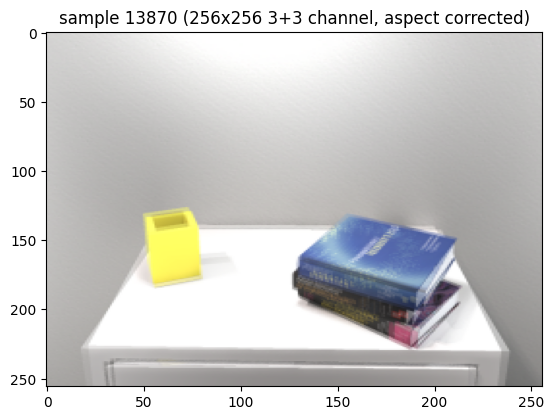

In [34]:
l, r = load_stereo_image(index="13870", dataset_path=DATASET_PATH, plot=True);
t, q, o = load_target_datapoint("./13870T.bin", dataset_path=DATASET_PATH)

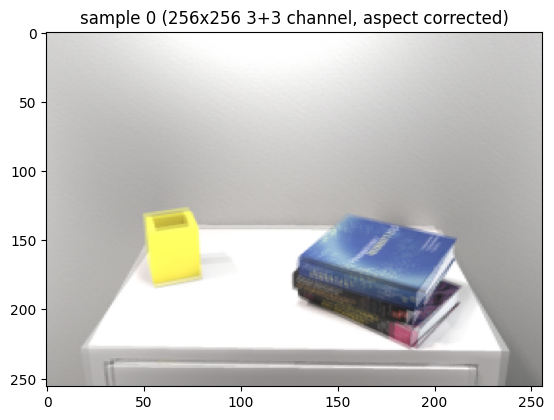

In [35]:
l, r = load_stereo_image(l_path="./Minidataset/train/13870L.png", r_path="./Minidataset/train/13870R.png", plot=True);

In [36]:
def make_model_input(l, r, permute=True):
    if permute:
        assert l.shape == (IMG_SIZE, IMG_SIZE, N_CHANNELS//2)
        assert r.shape == (IMG_SIZE, IMG_SIZE, N_CHANNELS//2)
        lr = torch.cat([l, r], dim=2).permute(2,0,1).float()
    else:
        assert l.shape == (N_CHANNELS//2, IMG_SIZE, IMG_SIZE)
        assert r.shape == (N_CHANNELS//2, IMG_SIZE, IMG_SIZE)
        lr = torch.cat([l, r], dim=0).float()
    return lr

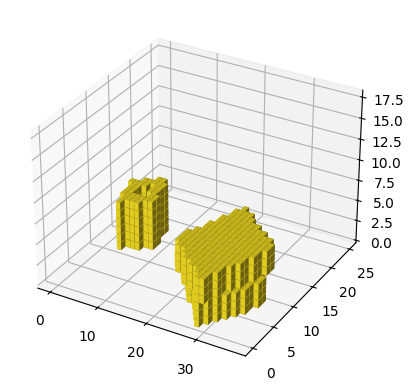

In [37]:
# Now let's have a look at the corresponding ground truth occupation grid

occupation = np.array(o, dtype='float32').reshape(37,25,18)
plot_3d(occupation)

In [38]:
np.max(occupation[0:4, 8:12, 0:5])

1.0

In [39]:
get_padded_size(np.zeros(occupation.shape), 48)

(15, 15, 12, 11, 6, 5)

In [40]:
occupation.shape

(37, 25, 18)

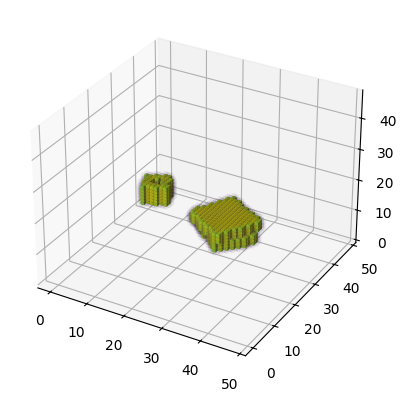

In [41]:
# We need to pad this to 48x48x48 for tensor shape compatibility

occ_padded = F.pad(torch.tensor(occupation), get_padded_size(np.zeros(occupation.shape), 48))
plot_3d(apply_gaussian_smoothing(occ_padded, 0.4))

## Data Loading
In this section we will prepare the DataLoader pipeline so we can efficiently feed data to the model during training

In [42]:
def permute_target_tensor(t):
    return torch.flip(t, dims=[2]).permute(2, 0, 1)

def unpermute_target_tensor(t):
    return torch.flip(t.permute(1, 2, 0), dims=[2])

def crop_output(t):
    return t[6:6+37, 12:12+25, 15:15+18]

def expand_output(t):
    return F.pad(t, get_padded_size(np.zeros(t.shape), 48))

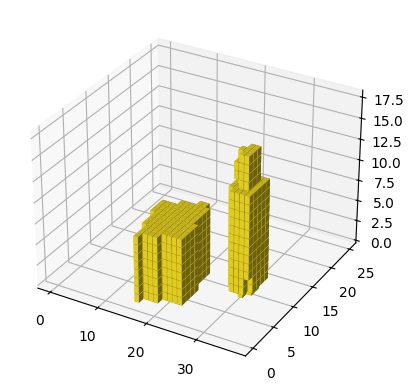

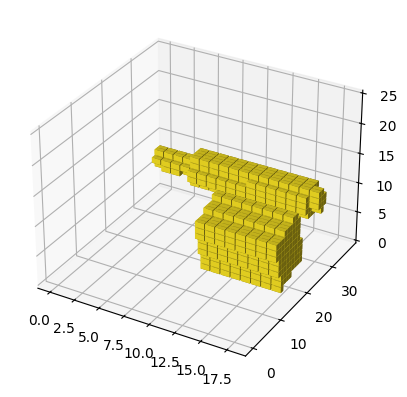

In [43]:
# Permutation of the data channels
t, q, o = load_target_datapoint("./Minidataset/train/13179T.bin")

o=np.array(o, dtype='float32').reshape(37,25,18)
plot_3d(torch.tensor(o).numpy())
plot_3d(permute_target_tensor(torch.tensor(o)).numpy())

In [44]:
t[0]/1000

0.35346652221679686

In [45]:
expanded = F.pad(torch.tensor(o), get_padded_size(np.zeros(o.shape), 48)).shape

In [46]:
expanded = expand_output(o)
#plot_3d(expanded.numpy())

TypeError: pad(): argument 'input' (position 1) must be Tensor, not numpy.ndarray

In [ ]:
expand_output(o)

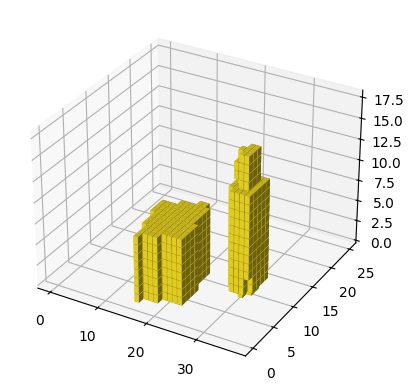

TypeError: tuple indices must be integers or slices, not tuple

In [47]:
plot_3d(o)
plot_3d(crop_output(expanded).numpy())

In [49]:
class CustomDataLoader(Dataset):
    def __init__(self, data_dir, transform=None, additional_param=None):
        self.data_dir = data_dir
        self.transform = transform
        self.l_img_list = []
        self.r_img_list = []
        self.gt_list = []
        self.additional_param = additional_param
        for file in sorted(os.listdir(data_dir)):
            if file.endswith("L.png"):
                self.l_img_list.append(os.path.join(data_dir, file))
            elif file.endswith("R.png"):
                self.r_img_list.append(os.path.join(data_dir, file))
            elif file.endswith("T.bin"):
                self.gt_list.append(os.path.join(data_dir, file))   
        
    def __len__(self):
        return len(self.gt_list)

    def __getitem__(self, idx):        
        l, r = load_stereo_image(l_path=self.l_img_list[idx], r_path=self.r_img_list[idx]);
        t, q, o = load_target_datapoint(self.gt_list[idx])

        # Apply transformations if specified
        if self.transform:
            l = self.transform(l)
            r = self.transform(r)

        #img = np.zeros((l.shape[0], 2*l.shape[1]))
        #img[:,:l.shape[1]] = l
        #img[:,l.shape[1]:] = r

        l = l.permute(2, 0, 1)
        r = r.permute(2, 0, 1)

        augment_contrast=self.additional_param['contrast'] if (self.additional_param is not None and 'contrast' in self.additional_param) else 0
        augment_saturation=self.additional_param['saturation'] if (self.additional_param is not None and 'saturation' in self.additional_param) else 0
        augment_brightness=self.additional_param['brightness'] if (self.additional_param is not None and 'brightness' in self.additional_param) else 0
        augment_hue=self.additional_param['hue'] if (self.additional_param is not None and 'hue' in self.additional_param) else 0
        augment_noise=self.additional_param['noise'] if (self.additional_param is not None and 'noise' in self.additional_param) else 0

        # Augment each image separately, as l and r cameras are independent

        l = transforms.functional.adjust_brightness(l, 1 + (random.random() - 0.5) * 2 * augment_brightness)
        l = transforms.functional.adjust_contrast(l, 1 + (random.random() - 0.5) * 2 * augment_contrast)
        l = transforms.functional.adjust_saturation(l, 1 + (random.random() - 0.5) * 2 * augment_saturation)
        l = transforms.functional.adjust_hue(l, (random.random() - 0.5) * 2 * augment_hue)
        noise = np.random.normal(0, augment_noise, l.shape).astype(np.float32)
        l = l + noise
        l = torch.clip(l, 0, 1)

        r = transforms.functional.adjust_brightness(r, 1 + (random.random() - 0.5) * 2 * augment_brightness)
        r = transforms.functional.adjust_contrast(r, 1 + (random.random() - 0.5) * 2 * augment_contrast)
        r = transforms.functional.adjust_saturation(r, 1 + (random.random() - 0.5) * 2 * augment_saturation)
        r = transforms.functional.adjust_hue(r, (random.random() - 0.5) * 2 * augment_hue)
        noise = np.random.normal(0, augment_noise, r.shape).astype(np.float32)
        r = r + noise
        r = torch.clip(r, 0, 1)
            
        X = make_model_input(l, r, permute=False)
            
        occupation = torch.tensor(np.array(o, dtype='float32').reshape(37,25,18))
        occupation = expand_output(occupation)
        y = permute_target_tensor(occupation)

        # Embed pose data in slice [:,:,0]
        #y[0,0,0:3] = torch.tensor(t)/1000 # <1 range
        #y[0,0,3:7] = torch.tensor(q)*1 # <1 range
        
        #occupation = apply_gaussian_smoothing(occupation, 0.4)
            
        #y = F.pad(torch.tensor(occupation), get_padded_size(np.zeros(occupation.shape), 48))

        return X, y

In [50]:
train_dataset_path = "/media/emilio/2TBDrive/robovision_train"
test_dataset_path = "/media/emilio/2TBDrive/robovision_test"

aug_params = {
    'contrast': 0.2,
    'brightness': 0.2,
    'saturation': 0.2,
    'hue': 0.2,
    'noise': 0.02
}
dataloader = CustomDataLoader(train_dataset_path)#, additional_param=aug_params)

In [51]:
debug_loader = DataLoader(dataloader)

In [52]:
for batch in debug_loader:
    y = batch[1]
    print(y[0,0,0,0:7])
    break

tensor([0., 0., 0., 0., 0., 0., 0.])


In [53]:
# Preprocessing

pos_weights = torch.ones((48, 48, 48))
total = 0
max_batch = 1000
for batch in debug_loader:
    y = batch[1]
    pos_weights += torch.sum(y, dim=0)
    total += y.shape[0]
    print(max_batch)
    max_batch-=1
    if max_batch == 0:
        break
pos_weights = (pos_weights/total) + 1
print(torch.max(pos_weights))

1000
999
998
997
996
995
994
993
992
991
990
989
988
987
986
985
984
983
982
981
980
979
978
977
976
975
974
973
972
971
970
969
968
967
966
965
964
963
962
961
960
959
958
957
956
955
954
953
952
951
950
949
948
947
946
945
944
943
942
941
940
939
938
937
936
935
934
933
932
931
930
929
928
927
926
925
924
923
922
921
920
919
918
917
916
915
914
913
912
911
910
909
908
907
906
905
904
903
902
901
900
899
898
897
896
895
894
893
892
891
890
889
888
887
886
885
884
883
882
881
880
879
878
877
876
875
874
873
872
871
870
869
868
867
866
865
864
863
862
861
860
859
858
857
856
855
854
853
852
851
850
849
848
847
846
845
844
843
842
841
840
839
838
837
836
835
834
833
832
831
830
829
828
827
826
825
824
823
822
821
820
819
818
817
816
815
814
813
812
811
810
809
808
807
806
805
804
803
802
801
800
799
798
797
796
795
794
793
792
791
790
789
788
787
786
785
784
783
782
781
780
779
778
777
776
775
774
773
772
771
770
769
768
767
766
765
764
763
762
761
760
759
758
757
756
755
754
753
752
751

## Model
This section will define the model that will be used for the training plus the training function and loss function(s)

In [54]:
import torch
import torch.nn as nn


def copy_inflate(input_tensor):
    # Get the shape of the input tensor
    batch_size, C, _, N = input_tensor.shape

    # Reshape the input tensor to add a singleton dimension at the end
    inflated_tensor = input_tensor.unsqueeze(-1)

    # Repeat the singleton dimension N times along the last axis
    inflated_tensor = inflated_tensor.expand(-1, -1, -1, -1, N)

    return inflated_tensor


class DoubleConv2D(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv2D, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        
    def forward(self, x):
        x = self.conv1(x)     
        x = self.bn1(x)     
        x = self.relu(x)       
        x = self.conv2(x)      
        x = self.bn2(x)     
        x = self.relu(x)       
        return x

        
class DoubleConv3D(nn.Module):
    """
    Double Convolution 3D
    """
    def __init__(self, in_channels, out_channels):
        super(DoubleConv3D, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv3d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv3d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm3d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)

    
class VoxelNet(nn.Module):
    """
    VoxelNet, U-Net inspired network which will
    map a 6 channel, stereo RGB image into a
    3d 64x64x64 occupation probability map
    """
    def __init__(self, in_channels, out_channels, steps=5):
        super(VoxelNet, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.residual_connections = nn.ModuleList()
        self.steps = steps

        features = [2 ** (i+4) for i in range(steps)]

        # Encoder
        for feature in features:
            #print(f" addinf out feature {feature}")
            self.encoder.append(
                    DoubleConv2D(in_channels, feature),
            )
            in_channels = feature

        out_ch = in_channels
        #print("We start with out_channels: ", out_channels)
        
        # Decoder
        for i in range(1,6):
            #print(f"      @[{i-1}], appending nn.ConvTranspose3d({out_ch*2}, {out_ch}, 2, 2)")
            #print(f"      @[{i-1}], appending DoubleConv3d({out_ch}, {out_ch//2})")
            # Let's try the last layer trick
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose3d(out_ch*2, out_ch, kernel_size=2 if i<5 else 3, stride=2 if i<5 else 3),
                    DoubleConv3D(out_ch, out_ch//2)
                )
            )
            out_ch = out_ch//2
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        #self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        
        encoder_outputs = []

        # Encoder
        for module in self.encoder:
            #print(x.shape)
            x = module(x)
            #print(x.shape)               
            #print(x.shape)
            x = self.pool(x)
            encoder_outputs.append(x)
            #print(x.shape)
            
        #encoder_outputs.append(x)
        #print("jo jo jo")
        #print(x.shape)
        x = x.unsqueeze(-1)
        #print(x.shape)
        
        #for outp in encoder_outputs:
        #    print(f"       we have this shape in encoder_outputs: {outp.shape}")
        #print("-------")
        
        # Decoder
        for i in range(1,6):
            #print(f"    --{i}")
            residual_connection = encoder_outputs[-i] #self.residual_connections[i//2](encoder_outputs[-(i//2+2)])
            #print(f"    res: {residual_connection.shape}")
            inflated_connection = copy_inflate(residual_connection)
            #print(f"    inf: {inflated_connection.shape}")
            #print(f"      x: {x.shape}")
            x = torch.cat([x, inflated_connection], dim=1)
            #print(f"      x.shape: {x.shape}")
            x = self.decoder[i-1](x)
            #print(f"      new x.shape: {x.shape}")
        
        x = self.final_conv(x).squeeze(dim=1)
        #print(x.shape)
        return x


In [55]:
class VoxelNet_v2(nn.Module):
    """
    VoxelNet, U-Net inspired network which will
    map a 6 channel, stereo RGB image into a
    3d 64x64x64 occupation probability map
    """
    def __init__(self, in_channels, out_channels, steps=5):
        super(VoxelNet_v2, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.residual_connections = nn.ModuleList()
        self.steps = steps

        features = [2 ** (i+4) for i in range(steps)]

        # Encoder
        for feature in features:
            #print(f" addinf out feature {feature}")
            self.encoder.append(
                    DoubleConv2D(in_channels, feature),
            )
            in_channels = feature

        out_ch = in_channels
        #print("We start with out_channels: ", out_channels)
        
        # Decoder
        for i in range(1,5):
            #print(f"      @[{i-1}], appending nn.ConvTranspose3d({out_ch*2}, {out_ch}, 2, 2)")
            #print(f"      @[{i-1}], appending DoubleConv3d({out_ch}, {out_ch//2})")
            # Let's try the last layer trick
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose3d(out_ch*2, out_ch, kernel_size=2 if i<4 else 3, stride=2 if i<4 else 3),
                    DoubleConv3D(out_ch, out_ch//2)
                )
            )
            out_ch = out_ch//2
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        #self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        self.final_conv = nn.Conv3d(64, out_channels, kernel_size=1)

    def forward(self, x):
        
        encoder_outputs = []

        # Encoder
        for module in self.encoder:
            #print(x.shape)
            x = module(x)
            #print(x.shape)               
            #print(x.shape)
            x = self.pool(x)
            encoder_outputs.append(x)
            #print(x.shape)
            
        #encoder_outputs.append(x)
        #print("jo jo jo")
        #print(x.shape)
        x = copy_inflate(x)#x.unsqueeze(-1)
        #print(x.shape)
        
        #for outp in encoder_outputs:
        #    print(f"       we have this shape in encoder_outputs: {outp.shape}")
        #print("-------")
        
        # Decoder
        for i in range(1,5):
            #print(f"    --{i}")
            residual_connection = encoder_outputs[-i] #self.residual_connections[i//2](encoder_outputs[-(i//2+2)])
            #print(f"    res: {residual_connection.shape}")
            inflated_connection = copy_inflate(residual_connection)
            #print(f"    inf: {inflated_connection.shape}")
            #print(f"      x: {x.shape}")
            x = torch.cat([x, inflated_connection], dim=1)
            #print(f"      x.shape: {x.shape}")
            x = self.decoder[i-1](x)
            #print(f"      new x.shape: {x.shape}")
        
        x = self.final_conv(x).squeeze(dim=1)
        #print(x.shape)
        return x

In [56]:
class VoxelNet_v3(nn.Module):
    """
    VoxelNet, U-Net inspired network which will
    map a 6 channel, stereo RGB image into a
    3d 64x64x64 occupation probability map
    """
    def __init__(self, in_channels, out_channels, steps=5):
        super(VoxelNet_v3, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.residual_connections = nn.ModuleList()
        self.steps = steps

        features = [2 ** (i+4) for i in range(steps)]

        # Encoder
        for feature in features:
            #print(f" addinf out feature {feature}")
            self.encoder.append(
                    DoubleConv2D(in_channels, feature),
            )
            in_channels = feature

        out_ch = in_channels
        #print("We start with out_channels: ", out_channels)
        
        # Decoder
        for i in range(1,6):
            #print(f"      @[{i-1}], appending nn.ConvTranspose3d({out_ch*2}, {out_ch}, 2, 2)")
            #print(f"      @[{i-1}], appending DoubleConv3d({out_ch}, {out_ch//2})")
            # Let's try the last layer trick
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose3d(out_ch*2, out_ch, kernel_size=2 if i<5 else 3, stride=2 if i<5 else 3),
                    DoubleConv3D(out_ch, out_ch//2)
                )
            )
            out_ch = out_ch//2
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        #self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        self.final_conv_1 = nn.Conv3d(64, 32, kernel_size=1)
        self.final_conv_2 = nn.Conv3d(32, 16, kernel_size=1)
        self.final_conv_3 = nn.Conv3d(16, 4, kernel_size=1)
        self.final_conv_4 = nn.Conv3d(4, out_channels, kernel_size=1)

        #self.pose_dense_1 = nn.Linear(2 ** (self.steps+4-1), 256)
        #self.pose_dense_2 = nn.Linear(256, 64)
        #self.pose_dense_3 = nn.Linear(64, 16)
        #self.pose_dense_4 = nn.Linear(16, 7)

    def forward(self, x, return_pose_predictors=False):
        
        encoder_outputs = []

        # Encoder
        for module in self.encoder:
            #print(x.shape)
            x = module(x)
            #print(x.shape)               
            #print(x.shape)
            x = self.pool(x)
            encoder_outputs.append(x)
            #print(x.shape)
            
        #encoder_outputs.append(x)
        #print("jo jo jo")
        #print(x.shape)
        
        if return_pose_predictors:
            x_pose = x[:,:,0,0]
            return x_pose
        
        x = x.unsqueeze(-1)
        
        #for outp in encoder_outputs:
        #    print(f"       we have this shape in encoder_outputs: {outp.shape}")
        #print("-------")
        
        # Decoder
        for i in range(1,6):
            #print(f"    --{i}")
            residual_connection = encoder_outputs[-i] #self.residual_connections[i//2](encoder_outputs[-(i//2+2)])
            #print(f"    res: {residual_connection.shape}")
            inflated_connection = copy_inflate(residual_connection)
            #print(f"    inf: {inflated_connection.shape}")
            #print(f"      x: {x.shape}")
            x = torch.cat([x, inflated_connection], dim=1)
            #print(f"      x.shape: {x.shape}")
            x = self.decoder[i-1](x)
            #print(f"      new x.shape: {x.shape}")
        
        x = self.final_conv_1(x)
        x = self.final_conv_2(x)
        x = self.final_conv_3(x)
        x = self.final_conv_4(x).squeeze(dim=1)

        #x_pose = self.pose_dense_1(x_pose)
        #x_pose = self.pose_dense_2(x_pose)
        #x_pose = self.pose_dense_3(x_pose)
        #x_pose = self.pose_dense_4(x_pose)
        #x[:,0,0,0:7] = x_pose
        #print(x.shape)
        return x


In [57]:
class VoxelNet_v4(nn.Module):
    """
    VoxelNet, U-Net inspired network which will
    map a 6 channel, stereo RGB image into a
    3d 64x64x64 occupation probability map
    """
    def __init__(self, in_channels, out_channels, steps=5):
        super(VoxelNet_v4, self).__init__()

        self.encoder = nn.ModuleList()
        self.decoder = nn.ModuleList()
        self.residual_connections = nn.ModuleList()
        self.steps = steps
        self.relu = nn.ReLU()
        self.mode = "occupancy"

        features = [2 ** (i+4) for i in range(steps)]

        # Encoder
        for feature in features:
            #print(f" addinf out feature {feature}")
            self.encoder.append(
                    DoubleConv2D(in_channels, feature),
            )
            in_channels = feature

        out_ch = in_channels
        #print("We start with out_channels: ", out_channels)
        
        # Decoder
        for i in range(1,6):
            #print(f"      @[{i-1}], appending nn.ConvTranspose3d({out_ch*2}, {out_ch}, 2, 2)")
            #print(f"      @[{i-1}], appending DoubleConv3d({out_ch}, {out_ch//2})")
            # Let's try the last layer trick
            self.decoder.append(
                nn.Sequential(
                    nn.ConvTranspose3d(out_ch*2, out_ch, kernel_size=2 if i<5 else 3, stride=2 if i<5 else 3),
                    DoubleConv3D(out_ch, out_ch//2)
                )
            )
            out_ch = out_ch//2
        
        self.pool = nn.MaxPool2d(kernel_size=2)

        #self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
        self.final_conv_1 = nn.Conv3d(64, 32, kernel_size=1)
        self.final_conv_2 = nn.Conv3d(32, 16, kernel_size=1)
        self.final_conv_3 = nn.Conv3d(16, 4, kernel_size=1)
        self.final_conv_4 = nn.Conv3d(4, out_channels, kernel_size=1)

        self.pose_dense_1 = nn.Linear(2 ** (self.steps+4-1), 256)
        self.pose_dense_2 = nn.Linear(256, 64)
        self.pose_dense_3 = nn.Linear(64, 16)
        self.pose_dense_4 = nn.Linear(16, 7)

    def set_mode(mode):
        freeze_pose = True
        if mode=='occupancy':
            freeze_pose = True
        elif mode=='pose':
            freeze_pose = False
        else:
            raise ValueException("Unknown mode")
        # Freeze layer1 and layer2
        for param in self.encoder.parameters():
            param.requires_grad = freeze_pose
        for param in self.decoder.parameters():
            param.requires_grad = freeze_pose
        for param in self.residual_connections.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_1.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_2.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_3.parameters():
            param.requires_grad = freeze_pose
        for param in self.final_conv_4.parameters():
            param.requires_grad = freeze_pose
        for param in self.pose_dense_1.parameters():
            param.requires_grad = !freeze_pose
        for param in self.pose_dense_2.parameters():
            param.requires_grad = !freeze_pose
        for param in self.pose_dense_3.parameters():
            param.requires_grad = !freeze_pose
        for param in self.pose_dense_4.parameters():
            param.requires_grad = !freeze_pose

    def forward(self, x):
        
        encoder_outputs = []

        # Encoder
        for module in self.encoder:
            #print(x.shape)
            x = module(x)
            #print(x.shape)               
            #print(x.shape)
            x = self.pool(x)
            encoder_outputs.append(x)
            #print(x.shape)
            
        #encoder_outputs.append(x)
        #print("jo jo jo")
        #print(x.shape)
        
        if self.mode == "pose":
            x_pose = x[:,:,0,0]
            x_pose = self.pose_dense_1(x_pose)
            x = self.relu(x_pose)
            x_pose = self.pose_dense_2(x_pose)
            x = self.relu(x_pose)
            x_pose = self.pose_dense_3(x_pose)
            x = self.relu(x_pose)
            x_pose = self.pose_dense_4(x_pose)
            return x_pose
        
        x = x.unsqueeze(-1)
        
        #for outp in encoder_outputs:
        #    print(f"       we have this shape in encoder_outputs: {outp.shape}")
        #print("-------")
        
        # Decoder
        for i in range(1,6):
            #print(f"    --{i}")
            residual_connection = encoder_outputs[-i] #self.residual_connections[i//2](encoder_outputs[-(i//2+2)])
            #print(f"    res: {residual_connection.shape}")
            inflated_connection = copy_inflate(residual_connection)
            #print(f"    inf: {inflated_connection.shape}")
            #print(f"      x: {x.shape}")
            x = torch.cat([x, inflated_connection], dim=1)
            #print(f"      x.shape: {x.shape}")
            x = self.decoder[i-1](x)
            #print(f"      new x.shape: {x.shape}")
        
        x = self.final_conv_1(x)
        x = self.relu(x)
        x = self.final_conv_2(x)
        x = self.relu(x)
        x = self.final_conv_3(x)
        x = self.relu(x)
        x = self.final_conv_4(x).squeeze(dim=1)

        #x[:,0,0,0:7] = x_pose
        #print(x.shape)
        return x

In [58]:
model_5 = VoxelNet_v4(in_channels=6, out_channels=1, steps=8).to(device)

count_parameters(model_5)

(279230528, 1116922112, '279M', '1065MB')

In [59]:
model = model_5

In [60]:
# Let's make one datapoint go through the network to make sure it all tensor shapes
# are coherent

in_data = make_model_input(l, r).unsqueeze(dim=0).to(device)
#out_data = occ_padded.unsqueeze(dim=0)

assert model.forward(in_data).shape == (1, 48, 48, 48)

## Training
This section will include a training function and the appropriate loss function

In [61]:
pos_weight = 0.75
def weighted_cross_entropy_with_logits(logits, labels):
    log_weight = 1 + (pos_weight - 1) * labels
    loss = (1 - labels) * logits + log_weight * (torch.log1p(torch.exp(-torch.abs(logits))) + F.relu(-logits))
    return loss

In [62]:
# Training function definition

def train_model(model, 
                dloader, 
                optimizer,
                config, 
                val_every_n_minibatches=1, 
                start_at=0, 
                initial_epoch=0,
                autosave_every=30, 
                num_epochs=10, 
                device=device, 
                debug=False, 
                name="untitled",
                validation=None, 
                log_to_wandb=False, 
                show_grad_norm=False):
    """
    Trains a torch model
    """
    print(f" initial lr: {config['initial_learning_rate']}, weight_decay: {config['weight_decay']}")
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights) # Criterion for the Multilabel Classification problem
    #criterion_pose = nn.L1Loss() #nn.MSELoss() # Criterion for the pose regressor
    last_lr = config['initial_learning_rate']

    # Agregamos scheduler de tipo ReduceLROnPlateau
    scheduler = ReduceLROnPlateau(optimizer, 
                                  mode='min', 
                                  factor=config['lrfactor'], 
                                  min_lr=config['min_lr'], 
                                  patience=config['patience'])

    dataset_length = None
    epoch_loss = -1
    epoch_misrate = 0
    total_batch_count = 0
    misclassified=0
    val_misclassified=0
    start_time = time.time()
    train_start_time = start_time

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        running_val_loss = 0.0
        running_mis = 0

        batch_step = 0
        batch_counter=0
        train_samples = 0
        for batch in dloader: # Takes a minibatch of data
            print(".", end="")
            inputs, targets = batch[0].to(device), batch[1].to(device)
            train_samples += inputs.shape[0]
            optimizer.zero_grad()  # Clears gradients

            outputs = model(inputs) # outputs are predictions
            #loss_class = criterion(outputs[:,1:,1:,:], targets[:,1:,1:,:]) # Calculates loss
            #loss_class = 0
            #loss_reg = criterion_pose(outputs[:,0,0,0:7], targets[:,0,0,0:7])
            #loss = loss_reg#loss_class + loss_reg
            #print(f"    - classif loss {loss_class}    reg loss {loss_reg}")
            loss = criterion(outputs, targets) # Calculates loss
            loss.backward()  # Backpropagation
            optimizer.step()  # Updates models parameters

            if log_to_wandb:
                wandb.log({'train_loss': loss.item(), 'misrate': misclassified, 'val_misrate': val_misclassified, 'val_loss': running_val_loss, 'epoch_loss':epoch_loss, 'lr': last_lr})

            if total_batch_count%val_every_n_minibatches == (val_every_n_minibatches-1):
                #print("Calculate miscl")
                misclassified = 0
                with torch.no_grad():
                    target_class = targets > 0.5
                    occ = torch.sigmoid(outputs)
                    occ = (occ-torch.min(occ)) / (torch.max(occ)-torch.min(occ))
                    pred_class = occ > 0.5
                    misclassified = (target_class != pred_class).sum().item()
                    print(misclassified)
                #pmis = misclassified / (val_input.shape[0]*48*48*48)
                running_mis += misclassified
            
            if epoch_loss < 0:
                epoch_loss = loss # Initialized epoch_loss

            running_loss += loss.item()
            #dataset_length = dslength
            print(f"bc: {batch_counter} / {val_every_n_minibatches}")
            if total_batch_count%val_every_n_minibatches == (val_every_n_minibatches-1) and validation!=None:
                print("Validation")

                #print(f" These are the train preds: \n {outputs}")
                #print(f" These are the train gt: \n\n {targets}")

                model.eval()
                with torch.no_grad():
                    val_batches = 0
                    running_val_loss = 0
                    running_val_mis = 0
                    for batch in validation:
                        print("-", end="")

                        val_input, val_targets = batch[0].to(device), batch[1].to(device)
                        val_batches += 1
                        val_pred = model(val_input)

                        #if val_batches == 1:
                        #    print(f" These are the test preds: \n {val_pred}")
                        #    print(f" These are the test gt: \n\n\n {val_targets}")

                        #val_pred_occ = val_pred[:,1:,1:,:]
                        #val_pred_pose = val_pred[:,0,0,0:7]
                        #val_targets_occ = val_targets[:,1:,1:,:]
                        #val_targets_pose = val_targets[:,0,0,0:7]
                        
                        #val_loss_class = criterion(val_pred, val_targets)
                        #val_loss_class = criterion(val_pred_occ, val_targets_occ) # Calculates loss
                        #val_loss_reg = criterion_pose(val_pred_pose, val_targets_pose)
                        #val_loss = loss_class + loss_reg
                        val_loss = criterion(val_pred, val_targets) # Calculates loss

                        val_target_class = val_targets > 0.5
                        val_misclassified = 0
                        val_occ = torch.sigmoid(val_pred)
                        val_occ = (val_occ-torch.min(val_occ)) / (torch.max(val_occ)-torch.min(val_occ))
                        val_pred_class = val_occ > 0.5
                        val_misclassified = (target_class != pred_class).sum().item()
                        
                        #target_class = val_targets > 0.5
                        #pred_class = torch.sigmoid(val_pred) > 0.5
                        #val_misclassified = (target_class != pred_class).sum().item()
                        #pmis = misclassified / (val_input.shape[0]*48*48*48)
                        running_val_mis += val_misclassified
                        
                        running_val_loss += val_loss.item()
                        #if batch_step > 0:
                    #print(val_batches)
                    if val_batches > 0:
                        running_val_loss = running_val_loss / val_batches
                        print(f"\nLoss: {loss.item()}, misrate: {misclassified}, val misrate: {val_misclassified}, val loss: {running_val_loss}, last val loss: {val_loss.item()} lr: {last_lr}  val batches: {val_batches}")
                        #batch_step = 0
                        if log_to_wandb:
                            wandb.log({'train_loss': loss.item(), 'misrate': misclassified, 'val_misrate': val_misclassified, 'val_loss': running_val_loss, 'epoch_loss':epoch_loss, 'lr': last_lr})
                    model.train() # Back to train mode
            else:
                if batch_step > 10:
                    print(f"Loss: {loss.item()}")
                    batch_step = 0
                if log_to_wandb:
                    wandb.log({'train_loss': loss.item(), 
                               'epoch_loss':epoch_loss, 
                               'lr': last_lr})
                        
            batch_step += 1
            #print(f" ... {batch_step} {config['limit_samples']} {config['batch_size']} {batches_in_set/10} ")

            #check_gpu_memory()
            #if total_batch_count < 200:
            #    print(".")
            #else:
            #    print("-")

            # Step the scheduler with the epoch_loss
            scheduler.step(loss.item()) # Actualiza scheduler de LR
            for param_group in optimizer.param_groups: # Lee lr actual
                last_lr = param_group['lr']

            batch_counter += 1
            total_batch_count += 1

            end_time = time.time()
            time_diff = end_time - start_time
            if time_diff > autosave_every:
                checkpoint = {
                    'epoch': epoch,
                    'model_state_dict': model.state_dict(),
                    'optimizer_state_dict': optimizer.state_dict(),
                    # 'additional_info': additional_info,  # Uncomment if you want to save additional information
                }

                # Save the checkpoint to disk
                #torch.save(checkpoint, checkpoint_path)
                torch.save(checkpoint, 
                           "./model_checkpoint_running_m{:}_r{:}_tl{:}_tm{:}_vm{:}_{:.2f}s.pth".format(
                               config['model'], 
                               name,
                               loss.item(),
                               misclassified,
                               val_misclassified,
                               start_at+end_time-train_start_time))
                start_time = time.time()

        for param_group in optimizer.param_groups: # Lee lr actual
            last_lr = param_group['lr']
        if validation!=None:
            epoch_loss = running_loss / batch_counter
            epoch_val_loss = running_val_loss / batch_counter
            epoch_misrate = running_mis / batch_counter
            print(f"\n\n   Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, Val loss: {epoch_val_loss}, lr: {last_lr}")
        else:
            epoch_loss = running_loss / (config['limit_samples']/config['batch_size'])
            print(f"\n\n   Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss}, lr: {last_lr}")
        if log_to_wandb:
            wandb.log({'train_loss': loss.item(), 'lr': last_lr})

    torch.save(model.state_dict(), f"./model_checkpoint_finish_{config['model']}.pth")

In [71]:
config = {
    'initial_learning_rate': 0.0002,
    'weight_decay': 0.00001,
    'lrfactor': 1/1.01,
    'model': 'VoxelNet_v4_2_correct',
    'description': 'With augmentation',
    'experiment': 1,
    'min_lr': 1e-8,
    'patience': 5
}

In [72]:
optimizer = optim.Adam(model.parameters(), lr=config['initial_learning_rate'], weight_decay=config['weight_decay'])

In [73]:
# start a new wandb run to track this script
run = wandb.init(
    # set the wandb project where this run will be logged
    project="MUIA UAX 2023 2024",

    # track hyperparameters and run metadata
    config=config
)

In [74]:
# First, debug training: try to overfit a few samples
# If the model is not capable of doing this, that's a clear
# sign that something is off

train_dataloader = CustomDataLoader(train_dataset_path, additional_param=aug_params)
train_loader = DataLoader(train_dataloader, batch_size=BATCH_SIZE)

test_dataloader = CustomDataLoader(test_dataset_path, additional_param=aug_params)
test_loader = DataLoader(test_dataloader, batch_size=BATCH_SIZE)

In [75]:
# Resume training

def find_latest_checkpoint(model_name, directory):
    latest_timestamp = float('-inf')  # Initialize with negative infinity
    latest_file = None

    # Traverse the directory
    for filename in os.listdir(directory):
        if filename.endswith(".pth") and filename.startswith(f"model_checkpoint_running_m{model_name}_"):
            parts = filename.split("_")
            timestamp_str = parts[-1].replace("s.pth", "")
            try:
                timestamp = float(timestamp_str)
                if timestamp > latest_timestamp:
                    latest_timestamp = timestamp
                    latest_file = os.path.join(directory, filename)
            except ValueError:
                pass  # Ignore filenames that can't be parsed as floats

    return latest_file, latest_timestamp

In [76]:
latest_checkpoint, initial_time = find_latest_checkpoint(config['model'], "./")
initial_epoch = 0
if latest_checkpoint is not None:
    # Load the weights from the checkpoint file
    print(f"Restoring checkpoint {latest_checkpoint}")
    checkpoint = torch.load(latest_checkpoint)

    # Load the model's state_dict from the checkpoint
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # Read latest epoch
    initial_epoch = checkpoint['epoch']
    
    # Load the optimizer's state_dict from the checkpoint
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
else:
    initial_time = 0

Restoring checkpoint ./model_checkpoint_running_mVoxelNet_v4_2_correct_runique-field-30_tl0.01030538510531187_tm10209_vm10209_343472.42s.pth


In [77]:
train_model(model,
            train_loader,
            optimizer,
            config,
            val_every_n_minibatches=40,
            start_at=0,
            initial_epoch=initial_epoch,
            autosave_every=1800,
            num_epochs=1224,
            device=device,
            debug=False,
            name=run.name,
            validation=test_loader,
            log_to_wandb=True,
            show_grad_norm=True)

 initial lr: 0.0002, weight_decay: 1e-05
.bc: 0 / 40
.bc: 1 / 40
.bc: 2 / 40
.bc: 3 / 40
.bc: 4 / 40
.bc: 5 / 40
.bc: 6 / 40
.bc: 7 / 40
.bc: 8 / 40
.bc: 9 / 40
.bc: 10 / 40
.bc: 11 / 40
Loss: 0.01020643301308155
.bc: 12 / 40
.bc: 13 / 40
.bc: 14 / 40
.bc: 15 / 40
.bc: 16 / 40
.bc: 17 / 40
.bc: 18 / 40
.bc: 19 / 40
.bc: 20 / 40
.bc: 21 / 40
.bc: 22 / 40
Loss: 0.010370256379246712
.bc: 23 / 40
.bc: 24 / 40
.bc: 25 / 40
.bc: 26 / 40
.bc: 27 / 40
.bc: 28 / 40
.bc: 29 / 40
.bc: 30 / 40
.bc: 31 / 40
.bc: 32 / 40
.bc: 33 / 40
Loss: 0.010570896789431572
.bc: 34 / 40
.bc: 35 / 40
.bc: 36 / 40
.bc: 37 / 40
.bc: 38 / 40
.12718
bc: 39 / 40
Validation
-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Loss: 0.011312807910144329, misrate: 12718, val misrate: 12718, val loss: 0.010351984846750794, last val loss: 0.010384747758507729 lr: 1.8133697453626236

KeyboardInterrupt: 

In [78]:
wandb.finish()

epoch_loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁████████████████▄▄▄▄▄▄▄▄
lr,██▇▇▆▆▅▅▅▄▄▄▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
misrate,▁█▇▇▇▆▆▇█▆▆▆▇▇▇█▇▇▆▆▇▇▆▇█▆▆█▇▇▇▇▆▇▇▇▆▆▆▆
train_loss,▆▅▆▃▆▄▅▄█▃▁▂▆▅▃▇▄▆█▆▅▆▄▆▅▃▂▂▆▆▅▃▃▆▃▆▄▄▅█
val_loss,▁██████████████████████████████▁████████
val_misrate,▁█▇▇▇▆▆▇█▆▆▆▇▇▇█▇▇▆▆▇▇▆▇█▆▆█▇▇▇▇▆▇▇▇▆▆▆▆
epoch_loss,0.00983
lr,0.0
misrate,9287
train_loss,0.00961
val_loss,0.00996


In [79]:
# Prepare DataLoader objects

#train_dataloader = CustomDataLoader("./Dataset/train")
#train_loader = DataLoader(train_dataloader)

#test_dataloader = CustomDataLoader("./Dataset/test")
#test_loader = DataLoader(test_dataloader)

In [80]:
device = "cpu"

In [81]:
model_gpu = model.to(device)

torch.Size([32, 6, 256, 256])
torch.Size([32, 48, 48, 48])
exe time: 0.3818960130447522


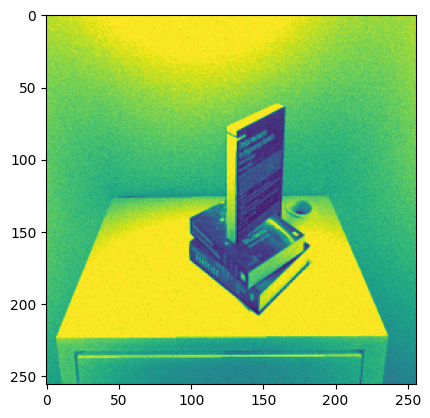

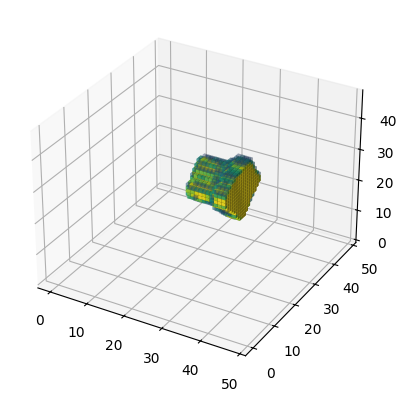

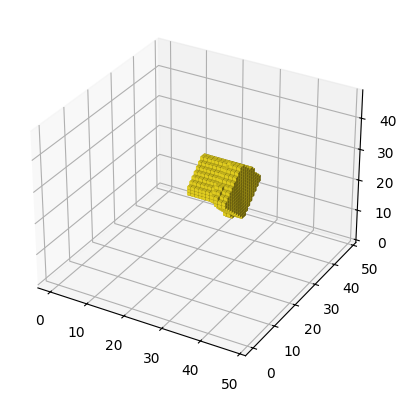

In [89]:
th = nn.Threshold(0.5, 0)
with torch.no_grad():
    idx = 5
    model.eval()
    for batch in test_loader:
        #count+=1
        #if count==1:
        #    continue
        X = batch[0].to(device)
        y = batch[1].to(device)
        print(X.shape)
        print(y.shape)
        plt.imshow(X[idx,0])
        start_time = time.perf_counter() # PERF
        pred = model(X[idx:idx+1])
        end_time = time.perf_counter() # PERF
        execution_time = end_time - start_time # PERF
        print(f"exe time: {execution_time}")
        #print(pred.shape)
        #print(y.shape)
        #print(f"pred: {pred[0,0,0,0:7]}")
        #print(f"gt: {y[0,0,0,0:7]}")
        occ = torch.sigmoid(pred)[0].detach().numpy()
        #print(np.min(occ))
        #print(np.max(occ))
        occ = (occ-np.min(occ)) / (np.max(occ)-np.min(occ))
        occ = (occ > 0.25) * occ # th
        plot_3d(occ)
        plot_3d(y[idx].detach().numpy())
        #print(criterion(pred, y[idx]))
        ##plot_3d(occ.detach().numpy())
        
        break

In [ ]:
for batch in debug_train_loader:
    print(batch[0].shape)
    print(batch[1].shape)
    break

In [ ]:
my_weights=torch.tensor([10, 1, 1, 11])

In [ ]:
my_truth = torch.tensor([[1., 0., 0., 1.], [0., 0., 1., 0.]]).float()

In [ ]:
my_preds = torch.tensor([[30, 0.34, -2, -40], [-10, -3, 4, -1]]).float()

In [ ]:
nn.BCEWithLogitsLoss(pos_weight=my_weights)(my_preds, my_truth)

## Trash

In [79]:
dibujito = torch.tensor([[[1, 1], [0, 0]], [[0, 1], [1, 0]], [[0, 0], [0, 1]]]).permute(1, 2, 0).float()
print(dibujito.shape)

torch.Size([2, 2, 3])


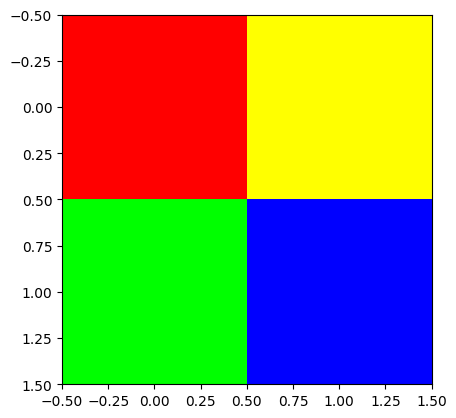

In [83]:
plt.imshow(dibujito)

In [88]:
dibujito[1,1,:]

tensor([0., 0., 1.])

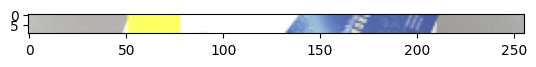

In [90]:
plt.imshow(l[150:160, :, :])

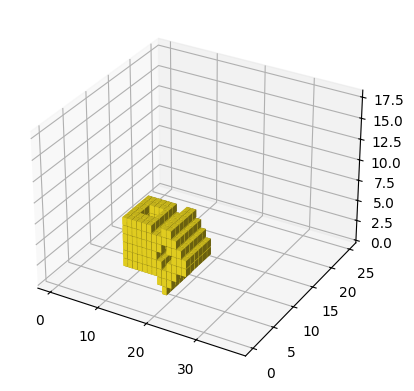

In [150]:
plot_3d(unpermute_target_tensor(crop_output(y[0])).numpy())

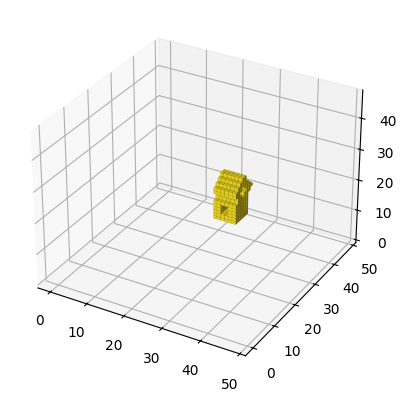

In [146]:
y_ = permute_target_tensor(y[0])
plot_3d(y_.numpy())

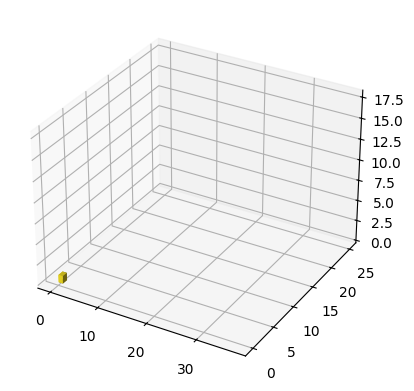

In [137]:
data = torch.zeros((37, 25, 18)).float()
data[0, 0, 0] = 1
plot_3d(data.numpy())

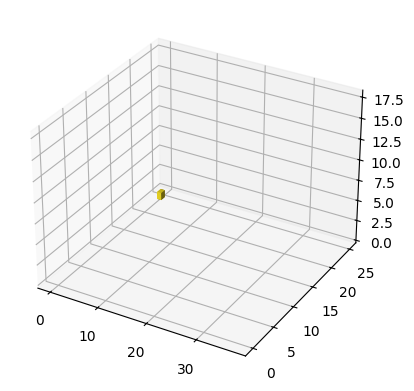

In [144]:
data = torch.zeros((18, 37, 25)).float()
data[17, 0, 23] = 1
plot_3d(unpermute_target_tensor(data).numpy())

In [127]:
data.shape

torch.Size([18, 37, 25])

In [128]:
unpermute_target_tensor(data).shape

torch.Size([37, 25, 18])

In [103]:
# Define dimensions
A, N = 3, 4  # Example dimensions

# Create a random tensor with shape (A, N, B)
x = torch.randn(A, N)

# Print the original tensor
print("Original tensor:")
print(x)

# Flip the second dimension (index 1)
x_flipped = torch.flip(x, dims=[0])

# Print the flipped tensor
print("\nFlipped tensor:")
print(x_flipped)

Original tensor:
tensor([[ 0.7306,  0.1461, -0.9739, -0.8510],
        [ 1.1516, -0.0080,  1.4767, -1.5439],
        [ 1.1540,  0.3756,  0.3738,  0.1907]])

Flipped tensor:
tensor([[ 1.1540,  0.3756,  0.3738,  0.1907],
        [ 1.1516, -0.0080,  1.4767, -1.5439],
        [ 0.7306,  0.1461, -0.9739, -0.8510]])


In [ ]:
class OccupancyEstimator(nn.Module):
    def __init__(self):
        pass
    
    def forward(self, x, debug_tensor_shape=False):
        pass

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(DoubleConv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, 3, 1, 1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, 3, 1, 1)
        self.bn2 = nn.BatchNorm2d(out_channels)

    def forward(self, x):
        print(x.shape)
        x = self.conv1(x)
        print(x.shape)        
        x = self.bn1(x)
        print(x.shape)        
        x = self.relu(x)
        print(x.shape)        
        x = self.conv2(x)
        print(x.shape)        
        x = self.bn2(x)
        print(x.shape)        
        x = self.relu(x)
        print(x.shape)        
        return x
    
def copy_inflate(input_tensor):
    # Get the shape of the input tensor
    batch_size, C, _, N = input_tensor.shape

    # Reshape the input tensor to add a singleton dimension at the end
    inflated_tensor = input_tensor.unsqueeze(-1)

    # Repeat the singleton dimension N times along the last axis
    inflated_tensor = inflated_tensor.expand(-1, -1, -1, -1, N)

    return inflated_tensor

class UNet(nn.Module):
    def __init__(self, in_channels, out_channels, n_steps):
        super(UNet, self).__init__()
        self.down = nn.ModuleList([
            
        ])
        self.conv1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = DoubleConv(64, 128)
        self.pool2 = nn.MaxPool2d(2)
        self.conv3 = DoubleConv(128, 256)
        self.pool3 = nn.MaxPool2d(2)
        self.conv4 = DoubleConv(256, 512)
        self.pool4 = nn.MaxPool2d(2)
        self.conv5 = DoubleConv(512, 1024)
        self.up6 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.conv6 = DoubleConv(1024, 512)
        self.up7 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.conv7 = DoubleConv(512, 256)
        self.up8 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.conv8 = DoubleConv(256, 128)
        self.up9 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.conv9 = DoubleConv(128, 64)
        self.conv10 = nn.Conv2d(64, out_channels, 1)

    def forward(self, x, debug_tensor_shapes=False):
        debug(debug_tensor_shapes, x.shape, 0, "UNet 1")
        c1 = self.conv1(x)
        debug(debug_tensor_shapes, c1.shape, 0, "UNet 2")        
        p1 = self.pool1(c1)
        debug(debug_tensor_shapes, p1.shape, 0, "UNet 3")        
        c2 = self.conv2(p1)
        debug(debug_tensor_shapes, c2.shape, 0, "UNet 4")        
        p2 = self.pool2(c2)
        debug(debug_tensor_shapes, p2.shape, 0, "UNet 5")        
        c3 = self.conv3(p2)
        debug(debug_tensor_shapes, c3.shape, 0, "UNet 6")        
        p3 = self.pool3(c3)
        debug(debug_tensor_shapes, p4.shape, 0, "UNet 7")        
        c4 = self.conv4(p3)
        debug(debug_tensor_shapes, c4.shape, 0, "UNet 8")
        p4 = self.pool4(c4)
        debug(debug_tensor_shapes, p4.shape, 0, "UNet 9")
        c5 = self.conv5(p4)
        debug(debug_tensor_shapes, c5.shape, 0, "UNet 10")        
        up_6 = self.up6(c5)
        debug(debug_tensor_shapes, up_6.shape, 0, "UNet 11")        
        merge6 = torch.cat([up_6, c4], dim=1)
        debug(debug_tensor_shapes, merge6.shape, 0, "UNet 12")        
        c6 = self.conv6(merge6)
        debug(debug_tensor_shapes, c6.shape, 0, "UNet 13")        
        up_7 = self.up7(c6)
        debug(debug_tensor_shapes, up_7.shape, 0, "UNet 14")        
        merge7 = torch.cat([up_7, c3], dim=1)
        debug(debug_tensor_shapes, merge7.shape, 0, "UNet 15")        
        c7 = self.conv7(merge7)
        debug(debug_tensor_shapes, c7.shape, 0, "UNet 16")        
        up_8 = self.up8(c7)
        debug(debug_tensor_shapes, up_8.shape, 0, "UNet 17")        
        merge8 = torch.cat([up_8, c2], dim=1)
        debug(debug_tensor_shapes, merge8.shape, 0, "UNet 18")        
        c8 = self.conv8(merge8)
        debug(debug_tensor_shapes, c8.shape, 0, "UNet 19")        
        up_9 = self.up9(c8)
        debug(debug_tensor_shapes, up_9.shape, 0, "UNet 20")        
        merge9 = torch.cat([up_9, c1], dim=1)
        debug(debug_tensor_shapes, merge9.shape, 0, "UNet 21")        
        c9 = self.conv9(merge9)
        debug(debug_tensor_shapes, c9.shape, 0, "UNet 22")        
        c10 = self.conv10(c9)
        debug(debug_tensor_shapes, c10.shape, 0, "UNet 23")        
        out = nn.Sigmoid()(c10)
        debug(debug_tensor_shapes, out.shape, 0, "UNet 24")        
        return out


In [ ]:
test_input_tensor = torch.tensor(np.random.randn(4*6*256*256).reshape(4, 6, 256, 256)).float()
test_output_tensor = torch.tensor(np.random.randn(4*64*64*64).reshape(4, 64, 64, 64)).float()